# Climate Data Store (CDS) - Example Backend

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of the proposed data delivering service. Example usage of the Climate Data Store (CDS) Backend for Radiosonde data.

For further information please refer to the Deliverable **DC3S311c_Lot2.3.1.1** on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend).


    Author: M. Blaschek
    Date: 01.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020
    

In [1]:
# check if necessary packages are install
!pip -q install numpy pandas scipy xarray netcdf4 h5py matplotlib numba cartopy

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])*100.

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

In [4]:
import xarray as xr
import requests, zipfile, io, os, time

/raid8/srvx1/mblaschek/.local/lib/python3.8/site-packages/ecmwflibs/__init__.py:131: UserWarning: ecmwflibs universal: found eccodes at /home/opt/spack/opt/spack/linux-centos6-sandybridge/gcc-5.3.0/enstools-2020.11.dev-apqn2tbqlk2j3lk3u5qae7vp5rx7flhj/lib/libeccodes.so
  warnings.warn(f"ecmwflibs universal: found {name} at {path}")


# Functionality of the delivering server

The backend expects HTTP POST requests, where the query string must be in JSON format. In the Deliverable Document Table 1 describes the allowed keys and values of the requests. HTTP GET requests may work as well but are accepted only for debugging.

The backend returns files, which are either
1. Zip files containing CF 1.7 compliant netCDF4 files  (one per station). The default name is download.zip.
2. JSON files containing error messages, if a HTTP error occurs


The interface can be a pure python code or via a linux shell.

* [Python Interface](#Python-version)
* [Shell Interface](#Shell)


A typical request should contain:
1. **statid** - the Station Identifier
    * e.g. `'11035' or ['11035','72357'] or 'all'`
2. **date** - datetime selection YYYYMMDD
    * e.g. `one day 19990101 or a range [19990101, 19991231]`
3. **pressure_level** - selection of pressure levels
    * e.g. `one level [85000] or [50000, 85000] or no keyword for all significant levels`
4. **variable** - selection of variables 
    * e.g. `'temperature', 'relative_humidity', ...`
5. **fbstats**  - feedback information from reanalysis
    * e.g. `'obs_minus_an', obs_minus_fg', ...`

## Python version

The requested data can be unzippped in memory to a data directory.

In [4]:
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
# http://srvx8.img.univie.ac.at:8004
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "10393",
                        "date": [20000101, 20000101],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "variable": ["temperature", "relative_humidity"],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data/1'):
    os.makedirs('./example_data/1')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Unzipping retrieved files: to ./exampla_data/1")
    print(z.namelist())
    z.extractall(path='./example_data/1')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Unzipping retrieved files: to ./exampla_data/1
['dest_0-20001-0-10393_air_temperature.nc', 'dest_0-20001-0-10393_relative_humidity.nc']
Time elapsed:  0.4026656150817871 s


## Shell

Another Way can be use a Linux tool called `curl` to download a zipfile. 
The request (`--data ...`) is identical to the above python request and also the retrieved file is identical. The retrieved file needs to be unzipped.


In [5]:
!curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"11035","date":[20000101,20000101],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://early-upper-air.copernicus-climate.eu

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71026  100 70750  100   276   264k   1057 --:--:-- --:--:-- --:--:--  266k


In [6]:
# The retrieved zipfile can be extracted:
!test -e example_data/download.zip && unzip -o example_data/download.zip -d example_data && rm example_data/download.zip

Archive:  example_data/download.zip
 extracting: example_data/dest_0-20001-0-11035_air_temperature.nc  
 extracting: example_data/dest_0-20001-0-11035_relative_humidity.nc  


In [10]:
# Show the new downloaded files in example_data directory
!ls -Rlh example_data/

example_data/:
total 72K
drwxr-xr-x. 2 mblaschek users 100 Jun 25 15:53 1
-rw-r--r--. 1 mblaschek users 35K Jun 25 13:53 dest_0-20001-0-11035_air_temperature.nc
-rw-r--r--. 1 mblaschek users 35K Jun 25 13:53 dest_0-20001-0-11035_relative_humidity.nc

example_data/1:
total 76K
-rw-r--r--. 1 mblaschek users 37K Jun 25 15:53 dest_0-20001-0-10393_air_temperature.nc
-rw-r--r--. 1 mblaschek users 35K Jun 25 15:53 dest_0-20001-0-10393_relative_humidity.nc


# Retrieved files

In [12]:
# Open Netcdf with Xarray
tdata = xr.open_dataset('example_data/1/dest_0-20001-0-10393_air_temperature.nc')
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 61, string11: 11, string14: 14, string20: 20, trajectory: 4)
Coordinates:
    lat               (obs) float32 ...
    lon               (obs) float32 ...
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 ...
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string20          (string20) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] ...
  * trajectory        (trajectory) int32 0 0 0 0
Data variables:
    report_id         (obs, string11) |S1 ...
    station_id        (obs, string20) |S1 ...
    ta                (obs) float32 ...
    trajectory_index  (obs) int32 ...
    trajectory_label  (trajectory, string14) |S1 ...
Attributes:
    Conventions:  CF-1.7
    source:       radiosonde
    featureType:  trajectory
    hist

## Variables

Notice that there are the following variables:
* `bias_estimate` - Reanalysis Bias estimate
* `obs_min_an` - Analysis Departures
* `obs_min_bg` - First Guess Departures
* `ta` - Observations, e.g. Air Temperature
* `trajectory_index` - unique profile identifier, where each observation belongs to
* `trajectory_label` - unique profile label, as in the CDM tables

Notice as well the differen Coordinates and Dimensions:
* `obs` - Dimension that corresponds to a record lenght (all profiles together)
* `trajectory`  - Dimension that corresponds to a number of individual profiles
* `lat` - Coordinate Information Latitude
* `lon` - Coordinate Information Longitude
* `plev` - Coordinate Information pressure
* `time` - Coordinate Information time

# Request a profile

Tasks:
* One station: `11035`
* One datetime: `20000101`
* Two variables: `temperature, relative humidity`
* Notice no `pressure_level`, thus requesting significant level data.

In [13]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
#
# All levels for one day
#
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20000101],
                        "variable": ["temperature", "relative_humidity"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data/2'):
    os.makedirs('./example_data/2')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data/2')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_0-20001-0-11035_air_temperature.nc', 'dest_0-20001-0-11035_relative_humidity.nc']
Time elapsed:  0.3085043430328369 s


## Read the NetCDF to xarray

In [14]:
# In case of NetCDF error might need to run again (unknown bug)
tdata = xr.load_dataset('example_data/2/dest_0-20001-0-11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/2/dest_0-20001-0-11035_relative_humidity.nc')

In [15]:
# This is the xarray representation of the NetCDF file
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 130, string11: 11, string14: 14, string25: 25, trajectory: 2)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.23 48.23 48.23
    lon               (obs) float32 16.37 16.37 16.37 ... 16.37 16.37 16.37
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 590.0 760.0 1e+03 ... 9.25e+04 9.57e+04
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string25          (string25) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
  * trajectory        (trajectory) int32 0 0
Data variables:
    report_id         (obs, string11) |S1 b'1' b'0' b'0' b'0' ... b'6' b'3' b'7'
    station_id        (obs, string25) |S1 b'W' b'I' b'E' b'N' ... b'-' b'0' b')'
    ta                (obs) 

## Plot a profile

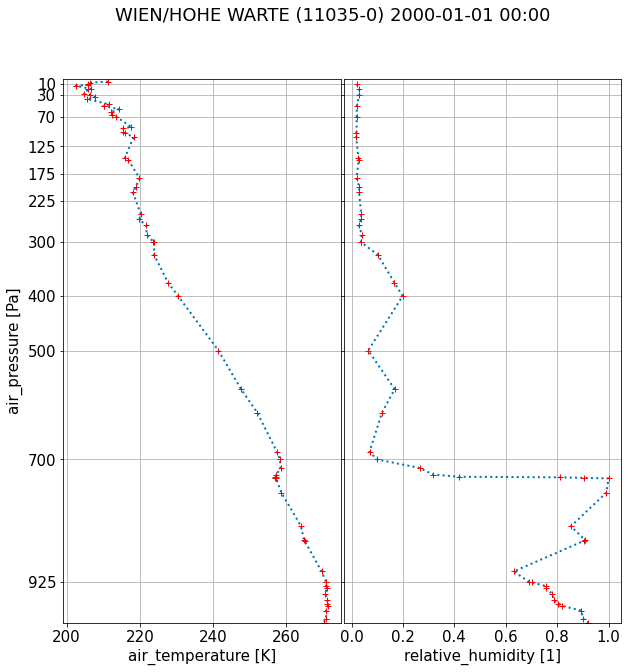

In [29]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.sel(obs=tdata.time.dt.hour==0).ta.swap_dims({'obs':'plev'}).to_dataset()
plotdata['hur'] = rdata.sel(obs=rdata.time.dt.hour==0).hur.swap_dims({'obs':'plev'})
#
# Plotting
#
f, [ax,ay] = subplots(1,2, sharey=True, figsize=(10,10))
plotdata.ta.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ax)
plotdata.hur.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ay)
# ax.set_yscale('log')
ax.set_yticks(ticks=yplevs)
ax.set_yticklabels(map("{:.0f}".format,yplevs/100))
ax.set_ylim(100000,100)
ay.set_ylim(100000,100)
ax.grid()
ay.grid()
ay.set_ylabel('')
subplots_adjust(wspace=0.01)
f.suptitle("{} {}".format("".join(tdata['station_id'][-1,:].values.astype(str)), 
                          plotdata.time.dt.strftime("%Y-%m-%d %H:%M").item(0)),);

# Request a timeseries

Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`


In [16]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20180101],
                        "variable": ["temperature", "relative_humidity"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data/3'):
    os.makedirs('./example_data/3')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data/3')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_0-20001-0-11035_air_temperature.nc', 'dest_0-20001-0-11035_relative_humidity.nc']
Time elapsed:  1.2169170379638672 s


## Read NetCDF to xarray

In [17]:
tdata = xr.load_dataset('example_data/3/dest_0-20001-0-11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/3/dest_0-20001-0-11035_relative_humidity.nc')

In [18]:
# Again the representation of the NetCDF file, 
# Notice the number of trajectories (13879), this is basically the amount of profiles in the file.
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 13702, string11: 11, string14: 14, string25: 25, trajectory: 13702)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.25 48.25 48.25
    lon               (obs) float32 16.37 16.37 16.37 ... 16.36 16.36 16.36
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 8.5e+04 8.5e+04 8.5e+04 ... 8.5e+04 8.5e+04
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string25          (string25) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01 ... 2018-01-01T23:30:27
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    report_id         (obs, string11) |S1 b'1' b'0' b'0' b'0' ... b'6' b'8' b'4'
    station_id        (obs, string25) |S1 b'W' b'I' b'E' b'N' .

## Plot a timeseries

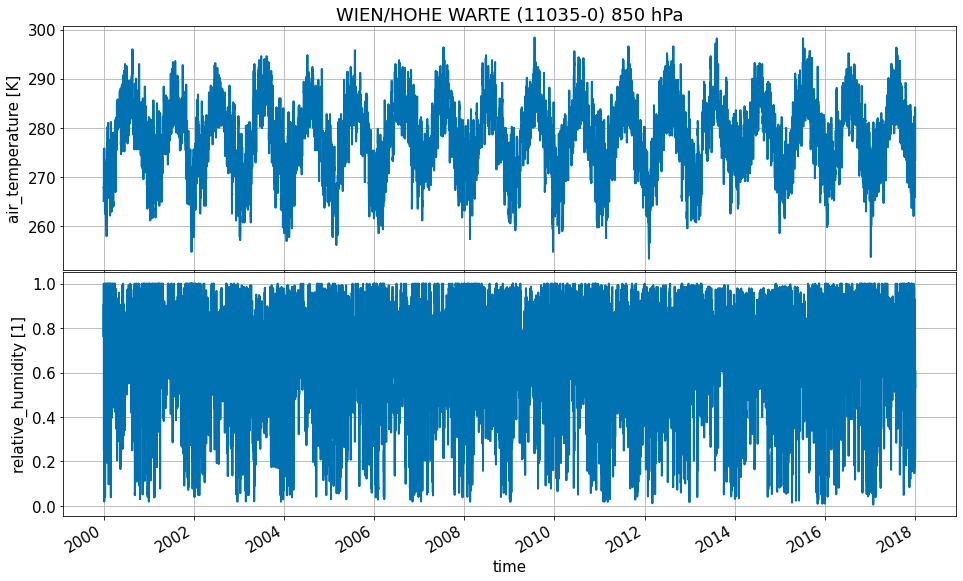

In [34]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.ta.swap_dims({'obs':'time'}).to_dataset()
plotdata['hur'] = rdata.hur.swap_dims({'obs':'time'})
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, figsize=(16,9))
plotdata.ta.dropna('time').plot(x='time', ax=ax)
plotdata.hur.dropna('time').plot(x='time', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
subplots_adjust(hspace=0.01)
ax.set_title("{} {:.0f} hPa".format("".join(tdata['station_id'][-1,:].values.astype(str)), 
                                    plotdata.plev.values[0]/100));

# Request multiple Stations

Tasks:
* 4 Stations: `11035,11010,11120,11240`
    - Vienna, Linz, Innsbruck and Graz. Four Stations from Austria
* One day: `20000101 - 20000101`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`

In [8]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": ["11035", "11010", "11120", "11240"],
                        "date": [20000101, 20000101],
                        "variable": ["temperature"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data/4'):
    os.makedirs('./example_data/4')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data/4')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_0-20001-0-11035_air_temperature.nc', 'dest_0-20000-0-11010_air_temperature.nc', 'dest_0-20000-0-11120_air_temperature.nc', 'dest_0-20000-0-11240_air_temperature.nc']
Time elapsed:  0.5201776027679443 s


## Read NetCDF to xarray

In [5]:
data = {}
ipath = './example_data/4/'
for ifile in os.listdir(ipath):
    if not '.nc' in ifile:
        continue
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset(ipath + ifile)
    if tmp.time.dims[0] == 'time':
        tmp['time'] = tmp.time.swap_dims({'time': 'obs'})
    tmp = tmp.swap_dims({'obs':'time'})
    #
    # Add Sonde ID as coordinate
    #
    ident = "".join(tmp.station_id.values[-1,:].astype(str))
    tmp = tmp.ta
    tmp.coords['sonde'] = ident
    data[ident] = tmp
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [6]:
print(data)

<xarray.DataArray 'ta' (sonde: 4, time: 5)>
array([[265.1 ,    nan,    nan,    nan, 266.3 ],
       [   nan,    nan, 266.9 ,    nan,    nan],
       [266.5 ,    nan,    nan,    nan,    nan],
       [265.65, 265.7 ,    nan, 265.65,    nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (sonde, time) float32 48.23 nan nan nan ... 47.0 nan 46.99 nan
    lon      (sonde, time) float32 16.37 nan nan nan ... 15.43 nan 15.44 nan
    obs      (sonde, time) float64 0.0 nan nan nan 0.0 ... 0.0 0.0 nan 0.0 nan
    plev     (sonde, time) float32 8.5e+04 nan nan nan ... nan 8.5e+04 nan
  * sonde    (sonde) <U25 'WIEN/HOHE WARTE (11035-0)' ... 'GRAZ-THALERHOF-FLU...
Attributes:
    cdmname:        observations_table/observation_value
    units:          K
    standard_name:  air_temperature
    cdsname:        temperature


## Merged Dataset

Notice that we have 4 Sondes and 4 times. This happens because the reported times are launch times. 

We can have a look at the temperature information. 
1. Vienna (11035) has soundings at 00Z and 12Z
2. Linz (11010) has one sounding at 05Z
3. Innsbruck (11120) has one sounding at 00Z
4. Graz (11240) has one sounding at 04Z

## Preparing plotdata

In order to have a common datetime we choose here to interpolate to 06Z as a common time.
To do this be need to fill the missing information and linearly interpolate to the time:
1. `interpolate_na`, interpolate missing values, only possible for Vienna, because 04Z and 05Z lie between 00Z and 12Z.
2. `ffill`, forward fill, copies the information to other times.
3. `interp`, linearly interpolates to the wanted time 06Z.
    - Note only for Vienna the value is interpolated between 05Z and 12Z

In [7]:
plotdata = data.interpolate_na('time')  # Interpolate
print(plotdata)

<xarray.DataArray 'ta' (sonde: 4, time: 5)>
array([[265.1  , 265.5  , 265.6  , 265.7  , 266.3  ],
       [    nan,     nan, 266.9  ,     nan,     nan],
       [266.5  ,     nan,     nan,     nan,     nan],
       [265.65 , 265.7  , 265.675, 265.65 ,     nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (sonde, time) float32 48.23 nan nan nan ... 47.0 nan 46.99 nan
    lon      (sonde, time) float32 16.37 nan nan nan ... 15.43 nan 15.44 nan
    obs      (sonde, time) float64 0.0 nan nan nan 0.0 ... 0.0 0.0 nan 0.0 nan
    plev     (sonde, time) float32 8.5e+04 nan nan nan ... nan 8.5e+04 nan
  * sonde    (sonde) <U25 'WIEN/HOHE WARTE (11035-0)' ... 'GRAZ-THALERHOF-FLU...
Attributes:
    cdmname:        observations_table/observation_value
    units:          K
    standard_name:  air_temperature
    cdsname:        temperature


In [8]:
# reset_coords make lon, lat to variables and allows them to be filled as well, set_coords make lat,lon coordinates again, but filled with information now.
plotdata = plotdata.reset_coords(['lon', 'lat']).ffill('time').bfill('time').set_coords(['lon', 'lat'])
print(plotdata)

<xarray.Dataset>
Dimensions:  (sonde: 4, time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
  * sonde    (sonde) <U25 'WIEN/HOHE WARTE (11035-0)' ... 'GRAZ-THALERHOF-FLU...
    obs      (sonde, time) float64 0.0 nan nan nan 0.0 ... 0.0 0.0 nan 0.0 nan
    plev     (sonde, time) float32 8.5e+04 nan nan nan ... nan 8.5e+04 nan
    lat      (sonde, time) float32 48.23 48.23 48.23 48.23 ... 47.0 46.99 46.99
    lon      (sonde, time) float32 16.37 16.37 16.37 16.37 ... 15.43 15.44 15.44
Data variables:
    ta       (sonde, time) float32 265.1 265.5 265.6 265.7 ... 265.7 265.6 265.6


In [9]:
plotdata = plotdata.interp(time='2000-01-01 06:00:00')
print(plotdata)

<xarray.Dataset>
Dimensions:  (sonde: 4)
Coordinates:
  * sonde    (sonde) <U25 'WIEN/HOHE WARTE (11035-0)' ... 'GRAZ-THALERHOF-FLU...
    obs      (sonde) float64 nan nan nan nan
    plev     (sonde) float64 nan nan nan nan
    lat      (sonde) float64 48.23 48.23 47.27 46.99
    lon      (sonde) float64 16.37 14.18 11.35 15.44
    time     datetime64[ns] 2000-01-01T06:00:00
Data variables:
    ta       (sonde) float64 265.7 266.9 266.5 265.6


## Plot a map

In [10]:
# Cartopy can not easily be installed on Colab
import cartopy.crs as ccrs
import cartopy as cpy

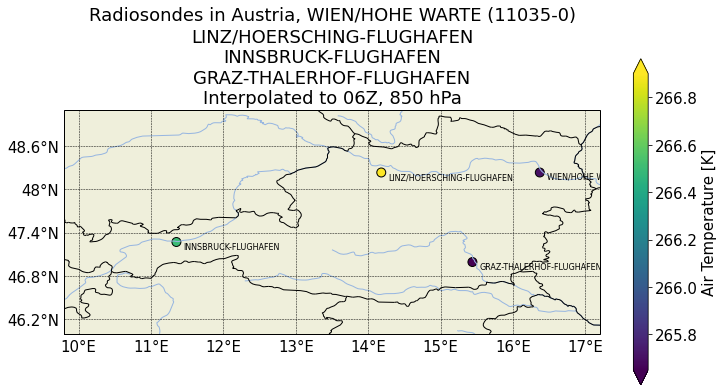

In [12]:
#
# Define the Plot
#
ax = plt.subplot(projection=ccrs.PlateCarree());
#
# Add Metainformation
#
ax.add_feature(cpy.feature.LAND, zorder=0)
ax.add_feature(cpy.feature.LAKES.with_scale('10m'), zorder=0)
ax.add_feature(cpy.feature.RIVERS.with_scale('10m'), zorder=1)
ax.add_feature(cpy.feature.BORDERS.with_scale('10m'), zorder=1)
#
# Plot the Values
#
cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                s=80,
                c=plotdata.ta.values,
                edgecolor='k',
                transform=ccrs.PlateCarree());
#
# Colorbar
#
cb = plt.colorbar(cs, ax=ax, extend='both')
cb.set_label("Air Temperature [K]")
ax.set_extent([9.8,17.2,46,49.1])   # set the extent of the map
#
# Add Labels
#
lloffset = [0.1]*4
for i, j, l, k in zip(plotdata.lon.values, plotdata.lat.values, plotdata.sonde.values, lloffset):
    ax.text(i + k, j, "{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=True)

ax.set_title("Radiosondes in Austria, " + "\n".join(plotdata.sonde.values) + "\nInterpolated to 06Z, 850 hPa");
#
# Gird lines
#
gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                  linewidth=0.5, linestyle='--', color='k')
gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Request a timeseries and convert to cube


Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* One variables: `temperature`
* Background Departures: `obs_minus_bg, obs_minus_an, bias_estimate`
* Standard pressure levels (#16)


In [13]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20180101],
                        "variable": ["temperature"],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data/5'):
    os.makedirs('./example_data/5')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data/5')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_0-20001-0-11035_air_temperature.nc']
Time elapsed:  1.2788031101226807 s


## Read NetCDF to xarray

In [17]:
tdata = xr.load_dataset('example_data/5/dest_0-20001-0-11035_air_temperature.nc')

In [19]:
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 203317, string11: 11, string14: 14, string25: 25, trajectory: 13810)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.25 48.25 48.25
    lon               (obs) float32 16.37 16.37 16.37 ... 16.36 16.36 16.36
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 1e+03 2e+03 3e+03 ... 7e+04 8.5e+04 9.25e+04
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string25          (string25) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01 ... 2018-01-01T23:30:27
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    report_id         (obs, string11) |S1 b'1' b'0' b'0' b'0' ... b'6' b'8' b'4'
    station_id        (obs, string25) |S1 b'W' b'I' b'E' b'N'

## Read NetCDF to xarray cube

In [21]:
import os, sys
euapath = os.getcwd()+'/../cds-backend/code/'
sys.path.append(euapath)
try:
    import cds_eua3 as eua
except:
    print('could not import eua')
    print('please download https://github.com/MBlaschek/CEUAS/blob/master/CEUAS/public/cds-backend/code/cds_eua3.py and save in ', euapath)
    print('or get the whole repository from https://github.com/MBlaschek/CEUAS')

In [22]:
with eua.CDMDataset('example_data/5/dest_0-20001-0-11035_air_temperature.nc') as iofile:
    ident = "".join(iofile.station_id[-1].astype(str))
    cube = iofile.read_data_to_3dcube('ta')
    # fix datum to datetime
    cube['ta']['datum'] = xr.decode_cf(xr.Dataset({'time': cube['ta'].datum}))['datum']
    # or
    #cube = iofile.read_data_to_cube('ta')

In [23]:
print(cube['ta'])

<xarray.DataArray 'ta' (hour: 2, press: 16, datum: 6576)>
array([[[205.9 ,    nan, 208.1 , ..., 218.26,    nan, 211.  ],
        [205.9 , 204.5 , 206.5 , ..., 212.97, 211.9 , 211.16],
        [206.3 , 208.1 , 206.7 , ..., 212.66, 212.79, 215.11],
        ...,
        [265.1 , 267.9 , 272.9 , ..., 277.36, 284.19, 273.48],
        [270.9 , 271.1 , 271.5 , ..., 281.13, 280.86, 278.07],
        [270.3 ,    nan, 274.8 , ...,    nan,    nan,    nan]],

       [[208.9 , 206.3 ,    nan, ..., 216.42, 212.36,    nan],
        [206.7 , 206.1 ,    nan, ..., 212.64, 210.94,    nan],
        [207.7 , 207.7 ,    nan, ..., 213.04, 209.48,    nan],
        ...,
        [266.3 , 267.7 , 275.6 , ..., 278.19, 273.66,    nan],
        [269.7 , 271.5 , 275.  , ..., 281.91, 278.12,    nan],
        [   nan, 271.7 , 270.3 , ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * hour     (hour) int64 0 12
  * press    (press) float64 10.0 20.0 30.0 50.0 ... 700.0 850.0 925.0 1e+03
  * datum    (

## Plot a timeseries

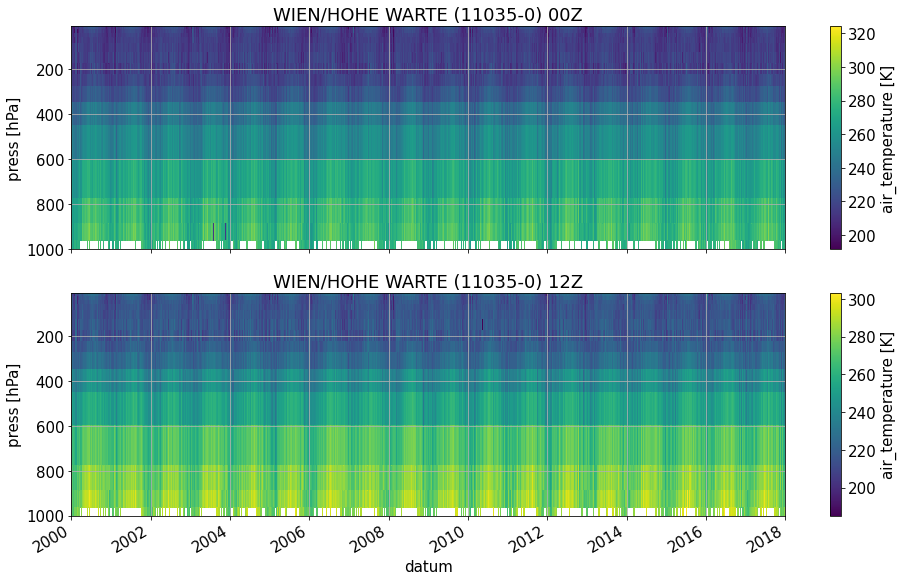

In [24]:
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
cube['ta'].sel(hour=0).plot(x='datum', y='press', ax=ax)
cube['ta'].sel(hour=12).plot(x='datum', y='press', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
ax.set_ylim(1000,10)
ax.set_title("{} {:02d}Z".format(ident, 0));
ay.set_title("{} {:02d}Z".format(ident, 12));

## Plot a profile

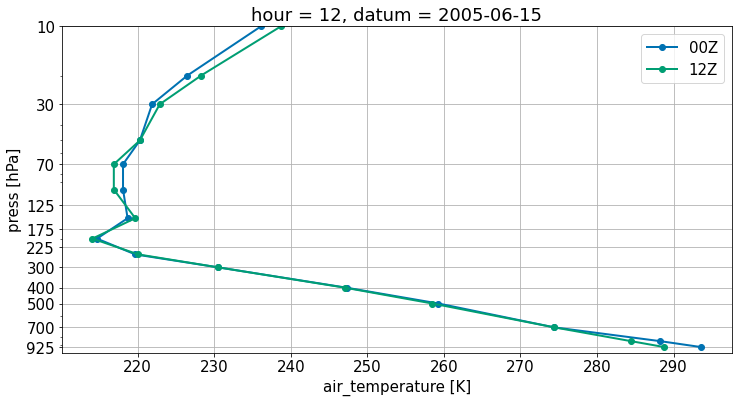

In [25]:
cube['ta'].sel(hour=0, datum='2005-06-15').plot(y='press', marker='o', label='00Z')
cube['ta'].sel(hour=12, datum='2005-06-15').plot(y='press', marker='o', label='12Z')
ylim(1000,10)
grid()
legend()
yscale('log')
yticks(ticks=yplevs/100, labels=map("{:.0f}".format,yplevs/100));